# Potentiel field method (2_layers)

In [ ]:
import gempy as gp
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import os
from geometron.geometries import gdf_to_points_gdf
# Setting options
np.random.seed(1515)
pd.set_option('precision', 2)

Importation of th geopackage into a geodataframe

In [3]:
gdf = gpd.read_file('../../../../data/Parties exploitées - Caillette.gpkg', layer = 'Parties exploitées - Caillette')

Rename of the column "Couche" into "layer"

In [4]:
gdf.rename({'Couche ': 'layer'}, axis=1, inplace=True)

Research and selection of the 2 main layers because others are less important and too isolated

In [5]:
gdf = gdf.query('layer=="10 Paumes" or layer=="Caillette"')

Creation of a rectangle which includes the points of the 2 layers

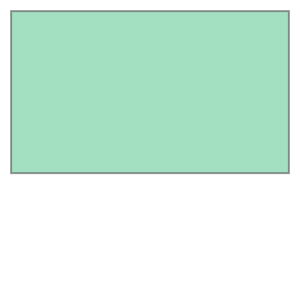

In [6]:
from shapely.geometry import Polygon
aoi = Polygon([[153400, 122500], [156400, 122500], [156400, 124250], [153400, 124250], [153400, 122500]])
aoi

Clip of the rectangle on the geodataframe

In [7]:
gdf = gpd.clip(gdf, aoi, True) 

Plot of the geodataframe

<AxesSubplot:>

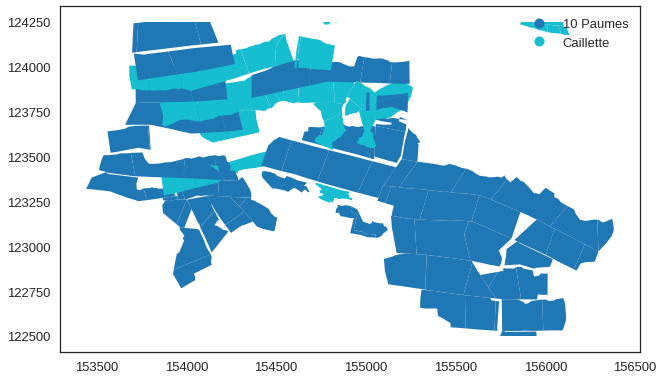

In [8]:
gdf.plot(column='layer', legend=True)

Creation of a geodatframe simplier than the first one with only the half of the points because it's enough

In [27]:
gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.simplify(10))

Plot of the second geodataframe

<AxesSubplot:>

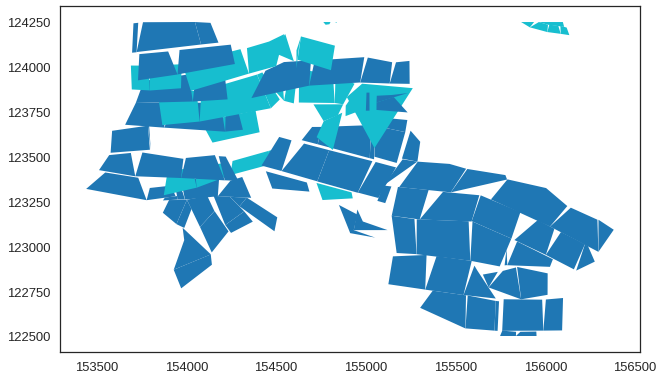

In [28]:
gdf.plot(column='layer')

Creation of the points from the geodataframe

In [29]:
gdf_points = gdf_to_points_gdf(gdf, columns=['layer'])
gdf_points.tail()

,geometry,layer
562,POINT Z (156105.420 124223.220 -509.300),Caillette
563,POINT Z (156015.589 124234.855 -509.950),Caillette
564,POINT Z (155962.909 124250.000 -509.893),Caillette
565,POINT Z (156098.197 124250.000 -495.015),Caillette
566,POINT Z (156105.420 124223.220 -509.300),Caillette


Conversion of the geodateframe into a csv file

In [30]:
gdf.to_csv('Parties exploitées - Caillette.csv')

Creation of the model with boundaries

In [31]:
geo_model = gp.create_model('Parties exploitées - Caillette')
geo_model = gp.init_data(geo_model, extent=[gdf_points.bounds.minx.min(), gdf_points.bounds.maxx.max(), gdf_points.bounds.miny.min(),  gdf_points.bounds.maxy.max(), gdf_points.geometry.z.min(), gdf_points.geometry.z.max()], resolution=[100, 100, 40])

Active grids: ['regular']


In [32]:
gp.set_interpolator(geo_model, theano_optimizer='fast_compile', verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              3452.04
$C_o$            283728.16
drift equations        [3]


Creation of the surfaces in the right order (from the younger to the older)

In [33]:
geo_model.add_surfaces(['Caillette', '10 Paumes','basement'])

,surface,series,order_surfaces,color,id
0,Caillette,Default series,1,#015482,1
1,10 Paumes,Default series,2,#9f0052,2
2,basement,Default series,3,#ffbe00,3


Creation of the surfaces points passing through each point for each layer

In [34]:
for idx, row in gdf_points.iterrows():
    geo_model.add_surface_points(row.geometry.x, row.geometry.y,row.geometry.z, surface=row.layer)

In [35]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Caillette,Default series,1,#015482,1
1,10 Paumes,Default series,2,#9f0052,2
2,basement,Default series,3,#ffbe00,3


Creation of the orientation of each points and layers

Here we don't have enough time to find how calculate the right orientation from points and surface point so we put a vertical orientation

In [36]:
for idx, row in gdf_points.iterrows():
    geo_model.add_orientations(row.geometry.x, row.geometry.y,row.geometry.z, surface=row.layer, pole_vector=(0, 0, 1))

In [37]:
geo_model.orientations

,X,Y,Z,G_x,G_y,G_z,smooth,surface
14,154725.03,123353.22,-713.00,0.0,0.0,1.0,0.01,Caillette
15,154920.55,123300.40,-703.00,0.0,0.0,1.0,0.01,Caillette
16,154927.30,123267.17,-707.00,0.0,0.0,1.0,0.01,Caillette
17,154758.67,123257.79,-715.00,0.0,0.0,1.0,0.01,Caillette
18,154725.03,123353.22,-713.00,0.0,0.0,1.0,0.01,Caillette
29,154257.25,123475.49,-752.40,0.0,0.0,1.0,0.01,Caillette
30,154458.02,123531.80,-727.80,0.0,0.0,1.0,0.01,Caillette
31,154474.38,123458.40,-731.70,0.0,0.0,1.0,0.01,Caillette
32,154245.05,123396.76,-746.20,0.0,0.0,1.0,0.01,Caillette
33,154257.25,123475.49,-752.40,0.0,0.0,1.0,0.01,Caillette


Compilation of the model

In [38]:
gp.compute_model(geo_model)


Lithology ids 
  [3. 3. 2. ... 1. 1. 1.] 

Plotting of the model

In [ ]:
gp.plot_2d(geo_model, cell_number=5, legend='force')


/home/gfa/.local/share/virtualenvs/GSDMA_2021-c2IPe6cS/lib/python3.8/site-packages/gempy/plot/plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


In [ ]:
gp.plot_3d(geo_model, kwargs_plot_structured_grid={'opacity': .3})

Exportation of the model in vtk format